In [ ]:
!pip install imagecodecs -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sentinel1_img = '/content/drive/MyDrive/Inference_data/Inference1_sentinel1_data2.tif'

In [ ]:
import numpy as np
import tensorflow as tf
import cv2 as cv2
import PIL
from PIL import Image, ImageOps
import os
import gdal
import tifffile as tif

def pad(save_dir,src_img, model_input_w, model_input_h):
    """
    Add extra black area to image to make it ready for cropping
    
    arguments:
        save_dir (Directory) : Directory to store your padded image
        src_img (PIL (or) np array): image to be padded
        model_input_w (int): input image width for model   
        model_input_h (int): input image height for model
    
    returns:
        PIL image: padded image
    """
    
    img_type = type(src_img)

    # change to numpy array
    if img_type  == np.ndarray : 
        img = src_img.copy()
    else: 
        img = np.array(src_img)
    
    img_width = img.shape[1]
    img_height = img.shape[0]
    
    pad_width = int((np.ceil(img_width / model_input_w) * model_input_w) - img_width)
    pad_height = int((np.ceil(img_height / model_input_h) * model_input_h) - img_height)
    
    print('image width = ', img_width, ', image height = ', img_height)
    print('pad width = ', pad_width, ', pad height = ', pad_height)
    
    result_image = cv2.copyMakeBorder( img, 0, pad_height, 0, pad_width, cv2.BORDER_CONSTANT)
    os.makedirs(save_dir,exist_ok= True)
    print('Padded Image shape',result_image.shape)
    tif.imwrite(str(save_dir)+'padded_image.tif',result_image)
    
    return result_image

def crop( gdal_dataset,model_input_w ,model_input_h ,save_dir):
    """
      gdal_dataset : read the tifffile using gdal.Open and pass it to gdal_dataset
      model_input_w : width of model input
      model_input_h : height of model input
      save_dir : Directory to store data


    """
    ds = gdal_dataset
    # ds = gdal.Open('/content/padded_img.tif')
    print(ds.ReadAsArray().shape)
    img_height = ds.ReadAsArray().shape[2]
    img_width  = ds.ReadAsArray().shape[1]

    os.makedirs(save_dir,exist_ok = True )

    box_list =[]
    arr = []
    for i in range(img_height//model_input_h):
        # hori = []
        for j in range(img_width//model_input_w):
            box = [j*model_input_w, i*model_input_h, 512,512]
            print("coordinates",box[:2])
            box_list.append(box[:2])
            # gdal.Translate('/content/cropped_images/cropped_images_'+str(i)+'_'+str(j)+'.tif',ds,srcWin=box)
            gdal.Translate(str(save_dir)+'cropped_images_'+str(i)+'_'+str(j)+'.tif',ds,srcWin=box)
            arr.append(str(save_dir)+'cropped_images_'+str(i)+'_'+str(j)+'.tif')

        
    
  
    return arr,box_list




def reconstruct(preds,img_height,img_width,model_input_h,model_input_w,box_list,numpy=False):
  pred_list = list(preds)

  tiles_list = [Image.fromarray(i, 'L') for i in pred_list]

  first_image = tiles_list[0]

  num_row = int(np.ceil(img_height / model_input_h))
  num_col = int(np.ceil(img_width / model_input_w))

  print(num_row,num_col)



  # create a blank sheet
  contact_sheet=PIL.Image.new(first_image.mode, (first_image.width * num_col,first_image.height * num_row))
  x, y = 0, 0
  for img,j in zip(tiles_list,box_list):
    # print(img,j)
    # paste a single tile in sheet
    contact_sheet.paste(img, j )
    # calculate next position
    if x+first_image.width == contact_sheet.width:
        x=0
        y=y+first_image.height
    else:
        x=x+first_image.width
  # remove extra padded area
  crop_box = (0, 0, 6666,7101)
  print(crop_box)
  new_img = contact_sheet.crop(crop_box)

  if numpy == True:
    new_img = np.array(new_img)



  return new_img


In [ ]:

padded_img = pad("/content/padded_image_v2/",tif.imread(sentinel1_img),512,512)

image width =  6666 , image height =  7101
pad width =  502 , pad height =  67
Padded Image shape (7168, 7168, 3)


In [ ]:
tif.imread(sentinel1_img).shape

(7101, 6666, 3)

In [ ]:
tif.imread('/content/padded_image_v2/padded_image.tif').shape

(7168, 7168, 3)

In [ ]:
original_img = tif.imread(sentinel1_img)
pad_img = tif.imread('/content/padded_image_v2/padded_image.tif')

Text(0.5, 1.0, '(7168, 7168, 3)')

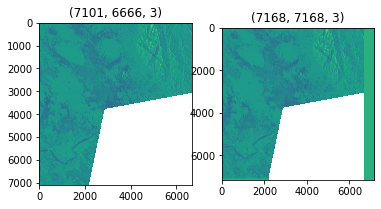

In [ ]:
import matplotlib.pyplot as plt
fig,(ax1,ax2)= plt.subplots(1,2)
ax1.imshow(original_img[:,:,0])
ax1.set_title(original_img.shape)
ax2.imshow(pad_img[:,:,0])
ax2.set_title(pad_img.shape)

In [ ]:

ds = gdal.Open('/content/padded_image_v2/padded_image.tif')
ds_arr = ds.ReadAsArray()
print(ds_arr.shape)

arr,box_list = crop(ds,512,512,'/content/test_cropped_version/')

(3, 7168, 7168)
(3, 7168, 7168)
coordinates [0, 0]
coordinates [512, 0]
coordinates [1024, 0]
coordinates [1536, 0]
coordinates [2048, 0]
coordinates [2560, 0]
coordinates [3072, 0]
coordinates [3584, 0]
coordinates [4096, 0]
coordinates [4608, 0]
coordinates [5120, 0]
coordinates [5632, 0]
coordinates [6144, 0]
coordinates [6656, 0]
coordinates [0, 512]
coordinates [512, 512]
coordinates [1024, 512]
coordinates [1536, 512]
coordinates [2048, 512]
coordinates [2560, 512]
coordinates [3072, 512]
coordinates [3584, 512]
coordinates [4096, 512]
coordinates [4608, 512]
coordinates [5120, 512]
coordinates [5632, 512]
coordinates [6144, 512]
coordinates [6656, 512]
coordinates [0, 1024]
coordinates [512, 1024]
coordinates [1024, 1024]
coordinates [1536, 1024]
coordinates [2048, 1024]
coordinates [2560, 1024]
coordinates [3072, 1024]
coordinates [3584, 1024]
coordinates [4096, 1024]
coordinates [4608, 1024]
coordinates [5120, 1024]
coordinates [5632, 1024]
coordinates [6144, 1024]
coordinates

In [ ]:
import glob
cropped_tiles = []
# cr_images =glob.glob('/content/cropped_images/*.tif')

for i in arr:
  cr_images_gdal= np.moveaxis(gdal.Open(i).ReadAsArray(),0,-1)
  cropped_tiles.append(cr_images_gdal)

cropped_tiles_arr = np.array(cropped_tiles)

In [ ]:
cropped_tiles_arr.shape

(196, 512, 512, 3)

In [ ]:
preds =cropped_tiles_arr[:,:,:,:1]

In [ ]:
preds = np.squeeze(preds)
preds.shape

(196, 512, 512)

In [ ]:
pred_list = list(preds)

tiles_list = [Image.fromarray(i, 'L') for i in pred_list]

first_image = tiles_list[0]

num_row = int(np.ceil(7168 / 512))
num_col = int(np.ceil(7168 / 512))

print(num_row,num_col)



# create a blank sheet
contact_sheet=PIL.Image.new(first_image.mode, (first_image.width * num_col,first_image.height * num_row))
x, y = 0, 0
for img,j in zip(tiles_list,box_list):
  # print(img,j)
  # paste a single tile in sheet
  contact_sheet.paste(img, j )
  # calculate next position
  if x+first_image.width == contact_sheet.width:
      x=0
      y=y+first_image.height
  else:
      x=x+first_image.width
# remove extra padded area
crop_box = (0, 0,6666,7101)
print(crop_box)
new_img = contact_sheet.crop(crop_box)



14 14
(0, 0, 6666, 7101)


In [ ]:
np.array(contact_sheet).shape,np.array(new_img).shape,original_img.shape

((7168, 7168), (7101, 6666), (7101, 6666, 3))

Text(0.5, 1.0, '(7168, 7168, 3)')

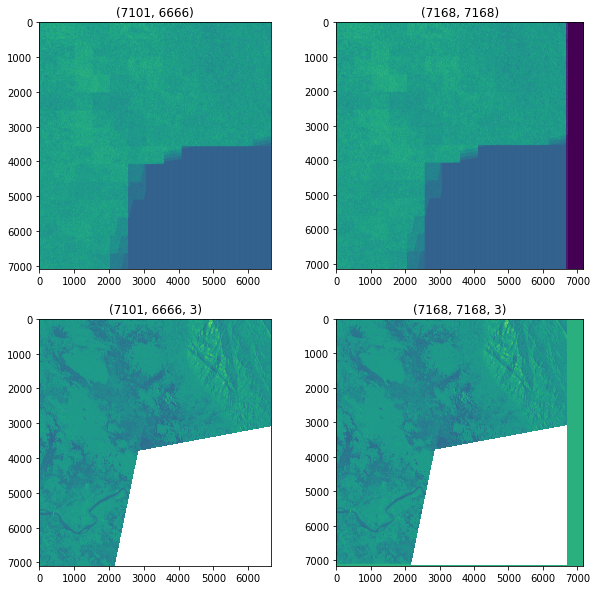

In [ ]:
import matplotlib.pyplot as plt
fig,((ax1,ax2),(ax3,ax4))= plt.subplots(2,2,figsize=(10,10))
ax1.imshow(new_img)
ax1.set_title(np.array(new_img).shape)
ax2.imshow(np.array(contact_sheet))
ax2.set_title(np.array(contact_sheet).shape)
ax3.imshow(original_img[:,:,0])
ax3.set_title(original_img.shape)
ax4.imshow(pad_img[:,:,0])
ax4.set_title(pad_img.shape)

Text(0.5, 1.0, '(7101, 6666, 3)')

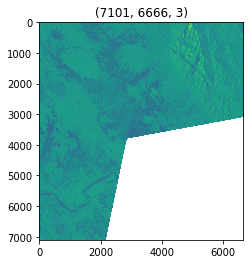

In [ ]:
plt.imshow(original_img[:,:,0])
plt.title(original_img.shape)